# Guided Project: Predicting the Stock Market

## Introduction

In this project, we'll be working with data from the [S&P500 Index](https://en.wikipedia.org/wiki/S%26P_500). The S&P500 is a stock market index.
We'll be using historical data on the price of the S&P500 Index to make predictions about future prices. Predicting whether an index will go up or down will help us forecast how the stock market as a whole will perform. Since stocks tend to correlate with how well the economy as a whole is performing, it can also help us make economic forecasts.

## The Stock Market

Some companies are publicly traded, which means that anyone can buy and sell their shares on the open market. A share entitles the owner to some control over the direction of the company, and to some percentage (or share) of the earnings of the company. When someone buys or sells shares, it's common to say that they're trading a stock.

The price of a share is based mainly on supply and demand for a given stock. For example, Apple stock has a price of 120 dollars per share as of December 2015. A stock that is in less demand, like Ford Motor Company, has a lower price. Stock price is also influenced by other factors, including the number of shares a company has issued.

Stocks are traded daily, and the price can rise or fall from the beginning of a trading day to the end based on demand. Stocks that are more in demand, such as Apple, are traded more often than stocks of smaller companies.

Indexes aggregate the prices of multiple stocks together, and allow us to see how the market as a whole is performing. The S&P500 Index aggregates the stock prices of 500 large companies. When an index fund goes up or down, one can say that the underlying market or sector it represents is also going up or down.

## Librairies Import

In [197]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from datetime import datetime
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

## The Data

We'll be working with a csv file containing index prices. Each row in the file contains a daily record of the price of the S&P500 Index from 1950 to 2015. The dataset is stored in `sphist.csv`.

The columns of the dataset are:

* `Date` -- The date of the record.
* `Open` -- The opening price of the day (when trading starts).
* `High` -- The highest trade price during the day.
* `Low` -- The lowest trade price during the day.
* `Close` -- The closing price for the day (when trading is finished).
* `Volume` -- The number of shares traded.
* `Adj Close` -- The daily closing price, adjusted retroactively to include any corporate actions.

We'll be using this dataset to develop a predictive model. We'll train the model with data from the period 1950-2012, and try to make predictions on the period 2013-2015.

Let's read the data!

In [198]:
sphist = pd.read_csv('sphist.csv')
sphist.head()

,Date,Open,High,Low,Close,Volume,Adj Close
0,2015-12-07,2090.419922,2090.419922,2066.780029,2077.070068,4.043820e+09,2077.070068
1,2015-12-04,2051.239990,2093.840088,2051.239990,2091.689941,4.214910e+09,2091.689941
2,2015-12-03,2080.709961,2085.000000,2042.349976,2049.620117,4.306490e+09,2049.620117
3,2015-12-02,2101.709961,2104.270020,2077.110107,2079.510010,3.950640e+09,2079.510010
4,2015-12-01,2082.929932,2103.370117,2082.929932,2102.629883,3.712120e+09,2102.629883


In [199]:
sphist.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16590 entries, 0 to 16589
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       16590 non-null  object 
 1   Open       16590 non-null  float64
 2   High       16590 non-null  float64
 3   Low        16590 non-null  float64
 4   Close      16590 non-null  float64
 5   Volume     16590 non-null  float64
 6   Adj Close  16590 non-null  float64
dtypes: float64(6), object(1)
memory usage: 907.4+ KB


We can see that our dataset doesn't contain any null values and will require no special data cleaning actions. However, we can note that the `Date` column is of object type and we'll want to have it as a date type to do date comparisons later on.

Let's make this conversion!

In [200]:
sphist['Date'] = pd.to_datetime(sphist['Date'], errors='coerce')

We also want to sort our dataframe on the `Date` column.

In [201]:
sphist.sort_values(by='Date', ascending=True, inplace=True)
sphist.reset_index(drop=True, inplace=True)
sphist.head(10)

,Date,Open,High,Low,Close,Volume,Adj Close
0,1950-01-03,16.660000,16.660000,16.660000,16.660000,1260000.0,16.660000
1,1950-01-04,16.850000,16.850000,16.850000,16.850000,1890000.0,16.850000
2,1950-01-05,16.930000,16.930000,16.930000,16.930000,2550000.0,16.930000
3,1950-01-06,16.980000,16.980000,16.980000,16.980000,2010000.0,16.980000
4,1950-01-09,17.080000,17.080000,17.080000,17.080000,2520000.0,17.080000
5,1950-01-10,17.030001,17.030001,17.030001,17.030001,2160000.0,17.030001
6,1950-01-11,17.090000,17.090000,17.090000,17.090000,2630000.0,17.090000
7,1950-01-12,16.760000,16.760000,16.760000,16.760000,2970000.0,16.760000
8,1950-01-13,16.670000,16.670000,16.670000,16.670000,3330000.0,16.670000
9,1950-01-16,16.719999,16.719999,16.719999,16.719999,1460000.0,16.719999


Our dataset is now ready for the next step, feature engineering.

## Feature Engineering

In this section, we engineer new features that could help us make better predictions on futur index prices.

Here are the indicators we want to generate for each row:
* The average price from the past 5 days.
* The average price for the past 30 days.
* The average price for the past 365 days.
* The ratio between the average price for the past 5 days and the average price for the past 365 days.
* The standard deviation of the price over the past 5 days.
* The standard deviation of the price over the past 365 days.
* The ratio between the standard deviation for the past 5 days and the standard deviation for the past 365 days.

"Days" means "trading days" -- so if we're computing the average of the past 5 days, it will be the 5 most recent dates before the current one. We use the closing price of the day from the `Close` column for computation.

We start by computing the average prices from the past 5, 30 and 365 days.

In [202]:
# Rolling mean uses the current day's price so we shift the result by one
sphist['avg_close_5'] = sphist['Close'].rolling(window=5).mean().shift()
sphist['avg_close_30'] = sphist['Close'].rolling(window=30).mean().shift()
sphist['avg_close_365'] = sphist['Close'].rolling(window=365).mean().shift()
sphist.head(10)

,Date,Open,High,Low,Close,Volume,Adj Close,avg_close_5,avg_close_30,avg_close_365
0,1950-01-03,16.660000,16.660000,16.660000,16.660000,1260000.0,16.660000,NaN,NaN,NaN
1,1950-01-04,16.850000,16.850000,16.850000,16.850000,1890000.0,16.850000,NaN,NaN,NaN
2,1950-01-05,16.930000,16.930000,16.930000,16.930000,2550000.0,16.930000,NaN,NaN,NaN
3,1950-01-06,16.980000,16.980000,16.980000,16.980000,2010000.0,16.980000,NaN,NaN,NaN
4,1950-01-09,17.080000,17.080000,17.080000,17.080000,2520000.0,17.080000,NaN,NaN,NaN
5,1950-01-10,17.030001,17.030001,17.030001,17.030001,2160000.0,17.030001,16.900,NaN,NaN
6,1950-01-11,17.090000,17.090000,17.090000,17.090000,2630000.0,17.090000,16.974,NaN,NaN
7,1950-01-12,16.760000,16.760000,16.760000,16.760000,2970000.0,16.760000,17.022,NaN,NaN
8,1950-01-13,16.670000,16.670000,16.670000,16.670000,3330000.0,16.670000,16.988,NaN,NaN
9,1950-01-16,16.719999,16.719999,16.719999,16.719999,1460000.0,16.719999,16.926,NaN,NaN


We then compute the standard deviation of the price over the past 5 and 365 days.

In [203]:
# Rolling standard deviation uses the current day's price so we shift the result by one
sphist['std_close_5'] = sphist['Close'].rolling(window=5).std().shift()
sphist['std_close_365'] = sphist['Close'].rolling(window=365).std().shift()
sphist.head(10)

,Date,Open,High,Low,Close,Volume,Adj Close,avg_close_5,avg_close_30,avg_close_365,std_close_5,std_close_365
0,1950-01-03,16.660000,16.660000,16.660000,16.660000,1260000.0,16.660000,NaN,NaN,NaN,NaN,NaN
1,1950-01-04,16.850000,16.850000,16.850000,16.850000,1890000.0,16.850000,NaN,NaN,NaN,NaN,NaN
2,1950-01-05,16.930000,16.930000,16.930000,16.930000,2550000.0,16.930000,NaN,NaN,NaN,NaN,NaN
3,1950-01-06,16.980000,16.980000,16.980000,16.980000,2010000.0,16.980000,NaN,NaN,NaN,NaN,NaN
4,1950-01-09,17.080000,17.080000,17.080000,17.080000,2520000.0,17.080000,NaN,NaN,NaN,NaN,NaN
5,1950-01-10,17.030001,17.030001,17.030001,17.030001,2160000.0,17.030001,16.900,NaN,NaN,0.157956,NaN
6,1950-01-11,17.090000,17.090000,17.090000,17.090000,2630000.0,17.090000,16.974,NaN,NaN,0.089051,NaN
7,1950-01-12,16.760000,16.760000,16.760000,16.760000,2970000.0,16.760000,17.022,NaN,NaN,0.067602,NaN
8,1950-01-13,16.670000,16.670000,16.670000,16.670000,3330000.0,16.670000,16.988,NaN,NaN,0.134796,NaN
9,1950-01-16,16.719999,16.719999,16.719999,16.719999,1460000.0,16.719999,16.926,NaN,NaN,0.196545,NaN


We can then compute the other indicators (ratio of averages and ratio of standard deviations) based on these new columns.

In [204]:
sphist['ratio_avg_close_5_365'] = sphist['avg_close_5'] / sphist['avg_close_365']
sphist['ratio_std_close_5_365'] = sphist['std_close_5'] / sphist['std_close_365']
sphist.head(10)

,Date,Open,High,Low,Close,Volume,Adj Close,avg_close_5,avg_close_30,avg_close_365,std_close_5,std_close_365,ratio_avg_close_5_365,ratio_std_close_5_365
0,1950-01-03,16.660000,16.660000,16.660000,16.660000,1260000.0,16.660000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1950-01-04,16.850000,16.850000,16.850000,16.850000,1890000.0,16.850000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1950-01-05,16.930000,16.930000,16.930000,16.930000,2550000.0,16.930000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1950-01-06,16.980000,16.980000,16.980000,16.980000,2010000.0,16.980000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1950-01-09,17.080000,17.080000,17.080000,17.080000,2520000.0,17.080000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1950-01-10,17.030001,17.030001,17.030001,17.030001,2160000.0,17.030001,16.900,NaN,NaN,0.157956,NaN,NaN,NaN
6,1950-01-11,17.090000,17.090000,17.090000,17.090000,2630000.0,17.090000,16.974,NaN,NaN,0.089051,NaN,NaN,NaN
7,1950-01-12,16.760000,16.760000,16.760000,16.760000,2970000.0,16.760000,17.022,NaN,NaN,0.067602,NaN,NaN,NaN
8,1950-01-13,16.670000,16.670000,16.670000,16.670000,3330000.0,16.670000,16.988,NaN,NaN,0.134796,NaN,NaN,NaN
9,1950-01-16,16.719999,16.719999,16.719999,16.719999,1460000.0,16.719999,16.926,NaN,NaN,0.196545,NaN,NaN,NaN


Since we're computing indicators that use historical data, there are some rows where there aren't enough historical data to generate them. Some of the indicators use 365 days of historical data. Hence, the columns relative to these indicators will feature NaNs up to the 365th row (index 364).

Let's remove all the rows with NaN values.

In [205]:
sphist_no_nans = sphist.dropna(axis=0)
sphist_no_nans.head(10)

,Date,Open,High,Low,Close,Volume,Adj Close,avg_close_5,avg_close_30,avg_close_365,std_close_5,std_close_365,ratio_avg_close_5_365,ratio_std_close_5_365
365,1951-06-19,22.020000,22.020000,22.020000,22.020000,1100000.0,22.020000,21.800,21.703333,19.447726,0.256223,1.790253,1.120954,0.143121
366,1951-06-20,21.910000,21.910000,21.910000,21.910000,1120000.0,21.910000,21.900,21.683000,19.462411,0.213659,1.789307,1.125246,0.119409
367,1951-06-21,21.780001,21.780001,21.780001,21.780001,1100000.0,21.780001,21.972,21.659667,19.476274,0.092574,1.788613,1.128142,0.051758
368,1951-06-22,21.549999,21.549999,21.549999,21.549999,1340000.0,21.549999,21.960,21.631000,19.489562,0.115108,1.787659,1.126757,0.064390
369,1951-06-25,21.290001,21.290001,21.290001,21.290001,2440000.0,21.290001,21.862,21.599000,19.502082,0.204132,1.786038,1.121008,0.114293
370,1951-06-26,21.299999,21.299999,21.299999,21.299999,1260000.0,21.299999,21.710,21.564333,19.513617,0.292831,1.783946,1.112556,0.164148
371,1951-06-27,21.370001,21.370001,21.370001,21.370001,1360000.0,21.370001,21.566,21.535000,19.525315,0.278980,1.781613,1.104515,0.156589
372,1951-06-28,21.100000,21.100000,21.100000,21.100000,1940000.0,21.100000,21.458,21.522000,19.537041,0.208015,1.779624,1.098324,0.116887
373,1951-06-29,20.959999,20.959999,20.959999,20.959999,1730000.0,20.959999,21.322,21.502333,19.548932,0.162080,1.775513,1.090699,0.091286
374,1951-07-02,21.100000,21.100000,21.100000,21.100000,1350000.0,21.100000,21.204,21.470667,19.560685,0.169205,1.770595,1.084011,0.095564


We are now ready to train and test a model.

## Training and Evaluation of the Model

For this project, we'll use a simple linear regression model that we will train on data from the 1950-2012 period and evaluate on data from the 2013-2015 period.

We create a function that groups the train/test sets split, the model training and its evaluation. This will prove especially useful later on if have to go through the same process again. 

In [206]:
def train_test(df, features):
    train = df[df['Date'] < datetime(year=2013, month=1, day=1)]
    test = df[df['Date'] > datetime(year=2012, month=12, day=31)]
    
    model = LinearRegression()
    model.fit(train[features], train['Close'])
    
    predictions = model.predict(test[features])
    
    mae = mean_absolute_error(test['Close'], predictions)
    
    return mae

We decided to use the Mean Absolute Error (MAE) as an error metric, because it will show how "close" we are to the price in intuitive terms. Mean Squared Error (MSE) is more commonly used but it will make it harder to intuitively tell how far off we will be from the true price because the error is squared.

For the model training, we decided to leave out all of the original columns (`Close`, `High`, `Low`, `Open`, `Volume`, `Adj Close`, `Date`) as they contain knowledge of the future that we don't want to feed the model.
We use the `Close` column as the target.

Let's now run this function on our `sphist_no_nans` dataframe.

In [207]:
features = ['avg_close_5', 'avg_close_30', 'avg_close_365', 'std_close_5', 'std_close_365', 'ratio_avg_close_5_365', 'ratio_std_close_5_365']

mae = train_test(sphist_no_nans, features)
print(mae)

16.14514060974372


We end up with an MAE of $16.1. How does this compare to the order of magnitude of `Close` values in the test set?

In [208]:
print(test['Close'].min())
print(test['Close'].max())

1457.150024
2130.820068


The mean absolute error on predictions we calculate amounts to just 1% of the minimum `Close` price of our test set. 

It is not so bad! But let's see if we can improve our model's performance by adding more indicators.

### Adding Volume Indicators

We will now engineer the two following features from the ones we already have:
* The average volume over the past five days
* The average volume over the past year

To compute those indicators, we need to go back to the step before we got rid of the null values in our `sphist` dataframe.

In [209]:
# Rolling mean uses the current day's volume so we shift the result by one
sphist['avg_vol_5'] = sphist['Volume'].rolling(window=5).mean().shift()
sphist['avg_vol_365'] = sphist['Volume'].rolling(window=365).mean().shift()
sphist.head(10)

,Date,Open,High,Low,Close,Volume,Adj Close,avg_close_5,avg_close_30,avg_close_365,std_close_5,std_close_365,ratio_avg_close_5_365,ratio_std_close_5_365,avg_vol_5,avg_vol_365
0,1950-01-03,16.660000,16.660000,16.660000,16.660000,1260000.0,16.660000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1950-01-04,16.850000,16.850000,16.850000,16.850000,1890000.0,16.850000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1950-01-05,16.930000,16.930000,16.930000,16.930000,2550000.0,16.930000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1950-01-06,16.980000,16.980000,16.980000,16.980000,2010000.0,16.980000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1950-01-09,17.080000,17.080000,17.080000,17.080000,2520000.0,17.080000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1950-01-10,17.030001,17.030001,17.030001,17.030001,2160000.0,17.030001,16.900,NaN,NaN,0.157956,NaN,NaN,NaN,2046000.0,NaN
6,1950-01-11,17.090000,17.090000,17.090000,17.090000,2630000.0,17.090000,16.974,NaN,NaN,0.089051,NaN,NaN,NaN,2226000.0,NaN
7,1950-01-12,16.760000,16.760000,16.760000,16.760000,2970000.0,16.760000,17.022,NaN,NaN,0.067602,NaN,NaN,NaN,2374000.0,NaN
8,1950-01-13,16.670000,16.670000,16.670000,16.670000,3330000.0,16.670000,16.988,NaN,NaN,0.134796,NaN,NaN,NaN,2458000.0,NaN
9,1950-01-16,16.719999,16.719999,16.719999,16.719999,1460000.0,16.719999,16.926,NaN,NaN,0.196545,NaN,NaN,NaN,2722000.0,NaN


We can now get rid of the null values again.

In [210]:
sphist_no_nans = sphist.dropna(axis=0)
sphist_no_nans.head(10)

,Date,Open,High,Low,Close,Volume,Adj Close,avg_close_5,avg_close_30,avg_close_365,std_close_5,std_close_365,ratio_avg_close_5_365,ratio_std_close_5_365,avg_vol_5,avg_vol_365
365,1951-06-19,22.020000,22.020000,22.020000,22.020000,1100000.0,22.020000,21.800,21.703333,19.447726,0.256223,1.790253,1.120954,0.143121,1196000.0,1.989479e+06
366,1951-06-20,21.910000,21.910000,21.910000,21.910000,1120000.0,21.910000,21.900,21.683000,19.462411,0.213659,1.789307,1.125246,0.119409,1176000.0,1.989041e+06
367,1951-06-21,21.780001,21.780001,21.780001,21.780001,1100000.0,21.780001,21.972,21.659667,19.476274,0.092574,1.788613,1.128142,0.051758,1188000.0,1.986932e+06
368,1951-06-22,21.549999,21.549999,21.549999,21.549999,1340000.0,21.549999,21.960,21.631000,19.489562,0.115108,1.787659,1.126757,0.064390,1148000.0,1.982959e+06
369,1951-06-25,21.290001,21.290001,21.290001,21.290001,2440000.0,21.290001,21.862,21.599000,19.502082,0.204132,1.786038,1.121008,0.114293,1142000.0,1.981123e+06
370,1951-06-26,21.299999,21.299999,21.299999,21.299999,1260000.0,21.299999,21.710,21.564333,19.513617,0.292831,1.783946,1.112556,0.164148,1420000.0,1.980904e+06
371,1951-06-27,21.370001,21.370001,21.370001,21.370001,1360000.0,21.370001,21.566,21.535000,19.525315,0.278980,1.781613,1.104515,0.156589,1452000.0,1.978438e+06
372,1951-06-28,21.100000,21.100000,21.100000,21.100000,1940000.0,21.100000,21.458,21.522000,19.537041,0.208015,1.779624,1.098324,0.116887,1500000.0,1.974959e+06
373,1951-06-29,20.959999,20.959999,20.959999,20.959999,1730000.0,20.959999,21.322,21.502333,19.548932,0.162080,1.775513,1.090699,0.091286,1668000.0,1.972137e+06
374,1951-07-02,21.100000,21.100000,21.100000,21.100000,1350000.0,21.100000,21.204,21.470667,19.560685,0.169205,1.770595,1.084011,0.095564,1746000.0,1.967753e+06


Now we call our function `train_and_test` on the updated `sphist_no_nans` dataframe containing the new indicators.

In [211]:
features.extend(['avg_vol_5', 'avg_vol_365'])

mae = train_test(sphist_no_nans, features)
print(mae)

16.14859733387378


The addition of the two new indicators based on volumes do not bring an improvement in performance.

Let's now break down the date in year, month and day components that we'll add as features for prediction and see if we get a performance gain.

### Adding Date Components

In [212]:
sphist['year'] = sphist['Date'].dt.year.astype(float)
sphist['month'] = sphist['Date'].dt.month.astype(float)
sphist['day'] = sphist['Date'].dt.day.astype(float)
sphist.head(5)

,Date,Open,High,Low,Close,Volume,Adj Close,avg_close_5,avg_close_30,avg_close_365,std_close_5,std_close_365,ratio_avg_close_5_365,ratio_std_close_5_365,avg_vol_5,avg_vol_365,year,month,day
0,1950-01-03,16.66,16.66,16.66,16.66,1260000.0,16.66,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1950.0,1.0,3.0
1,1950-01-04,16.85,16.85,16.85,16.85,1890000.0,16.85,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1950.0,1.0,4.0
2,1950-01-05,16.93,16.93,16.93,16.93,2550000.0,16.93,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1950.0,1.0,5.0
3,1950-01-06,16.98,16.98,16.98,16.98,2010000.0,16.98,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1950.0,1.0,6.0
4,1950-01-09,17.08,17.08,17.08,17.08,2520000.0,17.08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1950.0,1.0,9.0


Let's now get rid of the null values again and rerun our `train_test` function again on this updated dataframe.

In [213]:
sphist_no_nans = sphist.dropna(axis=0)

features.extend(['year','month','day'])

mae = train_test(sphist_no_nans, features)
print(mae)

16.17825219692074


Again, these new time indicators do not bring any performance gain. Domain knowledge in this field would be of great help to understand underlying index price evolution patterns and come up with the best features for prediction.

Let's finally try to make predictions only one day ahead to see if the performance improves.

### Predicting one day ahead

In this section, we want to verify if accuracy improves by making predictions only one day ahead. Predicting the price of the index far into the future with a model trained on date points far in the past is likely to not give good results.

We create a new function to handle this particular method.

In [214]:
def train_test_one_day(df, row, features):
    
    train = df[df['Date'] < row['Date']]
    test = df[df['Date'] == row['Date']]
    
    if len(train)==0:
        return np.nan
    else:
        model = LinearRegression()
        model.fit(train[features], train['Close'])
    
        predictions = model.predict(test[features])
    
        mae = mean_absolute_error(test['Close'], predictions)
    
    return mae

 And we apply it to each row of our `sphist_no_nans` dataframe and compute the average MAE.

In [215]:
mae = sphist_no_nans.apply(lambda row: train_test_one_day(sphist_no_nans, row, features), axis=1)
avg_mae = np.mean(mae)
std_mae = np.std(mae)
print(avg_mae)
print(std_mae)

5.482715949606076
9.861569049116314


The average MAE is significantly lower than previous values of MAE we computed. However, the standard deviation is quite high, indicating that the error in prediction varies a lot with the date. Let's quickly plot the MAE as a function of the date to confirm that.

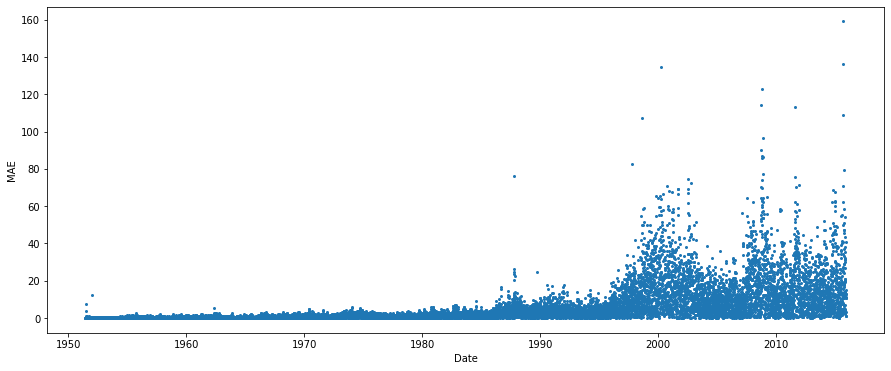

In [216]:
plt.figure(figsize=(15,6))
plt.scatter(sphist_no_nans['Date'], mae, s=4)
plt.xlabel('Date')
plt.ylabel('MAE')
plt.show()

As we can see on the plot above, the error on prediction varies a lot from day to day, especially after 1985.
A few spikes can be observed were the MAE value jumps high for a short period of time. It is unclear what this is due to. Rare and unpredictable events impacting the index price on these days may be what causes these high prediction errors. The democratisation of computers and the internet and the explosion of globalisation from 1990 may also be an explanation.

Funnily, we would have expected higher errors for the earlier dates as the model is trained on less data. But the stock market was maybe more predictable by then.

## Next Steps

There's a lot of improvement still to be made on the indicator side, and we could think of better indicators that we could use for prediction, such as:
* The ratio between the average volume for the past five days, and the average volume for the past year.
* The standard deviation of the average volume over the past five days.
* The standard deviation of the average volume over the past year.
* The ratio between the standard deviation of the average volume for the past five days, and the standard deviation of the average volume for the past year.
* The year component of the date.
* The ratio between the lowest price in the past year and the current price.
* The ratio between the highest price in the past year and the current price.
* The month component of the date.
* The day of week.
* The day component of the date.
* The number of holidays in the prior month.

We could also make significant structural improvements to the algorithm, and pull in data from other sources.

We could also try other techniques like random forest and see if they perform better.

Finally, the system could be made "higher-resolution". We made daily predictions, but we could make hourly, minute-by-minute, or second by second predictions. This will require obtaining more data, though. We could also make predictions for individual stocks instead of the S&P500.